### Notebook for training perturbation model

In [1]:
# Notebook setup
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.chdir('../')
import logging
import numpy as np
import pytorch_lightning as pl
import pandas as pd
import scanpy as sc
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
%load_ext autoreload
%autoreload 0

# assign number of cpus to use as data loaders
n_cpus = 10
seed = 42

# define label in .obs to classify
cls_label = 'cls_label'
batch_key = 'dataset'

/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `

In [37]:
# Set working directory
work_dir = '/home/xlv0877/proj_home/dl/'

In [38]:
# Set output directory for training
model_dir = os.path.join(work_dir, 'models', 'full')

2025-07-20 22:39:11,787 - INFO - Using perturbation direction to classify
2025-07-20 22:39:11,790 - INFO - Initializing dataset with 1171 classes
2025-07-20 22:39:11,794 - INFO - 1171 unique perturbations
2025-07-20 22:39:11,796 - INFO - 1171 unique gene-perturbations
2025-07-20 22:39:11,798 - INFO - 4 unique cell types
2025-07-20 22:39:11,800 - INFO - 7 datasets
2025-07-20 22:39:11,802 - INFO - Mean number of cells / perturbation 352.4568744662682
2025-07-20 22:39:11,803 - INFO - Class embedding shape: (12881, 1536)
2025-07-20 22:39:11,803 - INFO - Adata shape: (412727, 6407)


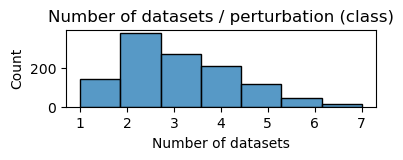

In [39]:
model_set = sc.read(os.path.join(work_dir, 'data/full.h5ad'))
# define all labels to classify on
if 'perturbation_direction' in model_set.obs.columns:
    logging.info('Using perturbation direction to classify')
    cls_labels = ['perturbation_direction', 'perturbation']
else:
    cls_labels = ['celltype', 'perturbation_type', 'perturbation']
likelihood = 'zinb'
# Check number of unique perturbations to classify
logging.info(f'Initializing dataset with {model_set.obs.cls_label.nunique()} classes')
logging.info(f'{model_set.obs[cls_labels[1:]].drop_duplicates().shape[0]} unique perturbations')
logging.info(f'{model_set.obs[cls_labels[-1]].nunique()} unique gene-perturbations')
logging.info(f'{model_set.obs["celltype"].nunique()} unique cell types')
logging.info(f'{model_set.obs["dataset"].nunique()} datasets')
logging.info(f'Mean number of cells / perturbation {model_set.obs.cls_label.value_counts().mean()}')
logging.info(f'Class embedding shape: {model_set.uns["cls_embedding"].shape}')
logging.info(f'Adata shape: {model_set.shape}')
fig = plt.figure(figsize=(4, 1))
ax = sns.histplot(model_set.obs.groupby('perturbation', observed=True).dataset.nunique(), bins=model_set.obs.dataset.nunique())
plt.title('Number of datasets / perturbation (class)')
plt.xlabel('Number of datasets')
plt.show()

### Check out raw data

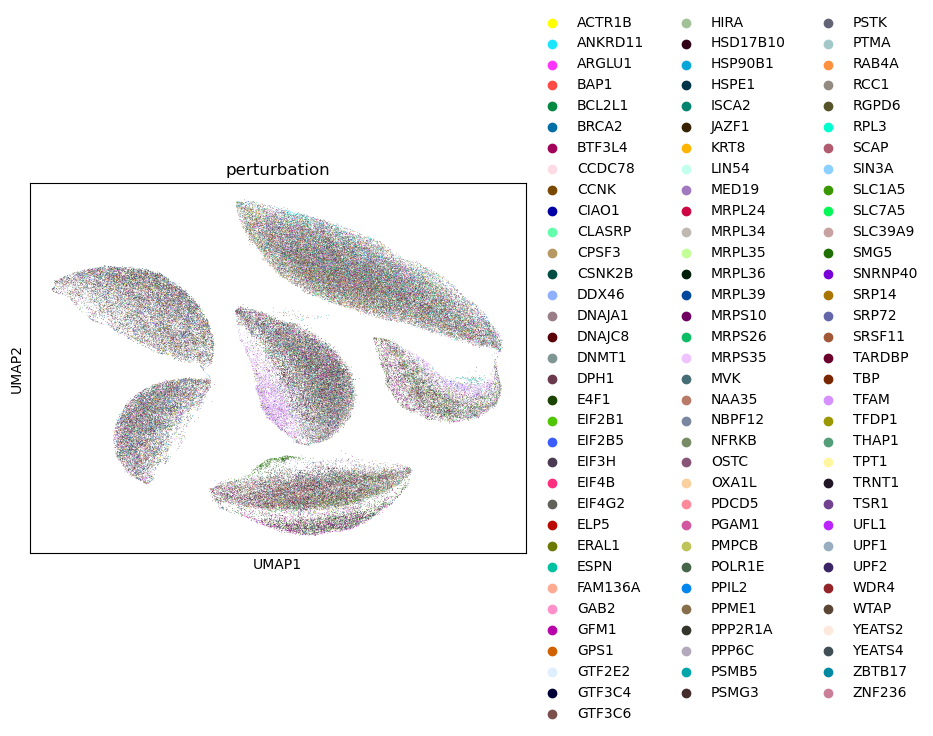

In [8]:
sc.pp.pca(model_set)
sc.pp.neighbors(model_set)
sc.tl.umap(model_set)
sc.pl.umap(model_set, color='perturbation')

### Pre-training on reconstruction only

In [6]:
from src.models._jedvi import JEDVI
from src.plotting import get_model_results

# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl')
train_params['logger'] = pl.loggers.TensorBoardLogger(step_model_dir)

data_params = {
    'train_size': 0.9,
    'batch_size': 512,
    'num_workers': 1,
    # Contrastive splitter parameters, cpp * cbp = batch_size
    'max_cells_per_batch': 32,
    'max_classes_per_batch': 16,
    'shuffle_classes': True,
    'use_contrastive_loader': None,
}
cls_params = {
    'n_hidden': 128, 'n_layers': 1, 'dropout_rate': 0.1,
    'use_multihead': False, 'use_cosine_similarity': True, 'temperature': 1
}
# Define encoder and decoder parameters
encoder_params = {
    'use_attention': False, 'min_attn_dim': 512, 'n_head': 4
}
decoder_params = {
    'use_attention': False, 'min_attn_dim': 512, 'n_head': 4
}

# Set model parameters
jedvae_params = {
    'n_latent': 64,                    # Final projection dimension
    'n_layers': 3,                        # Number of layers to get there
    'n_hidden': 256,                         # Set to 0 to enable funneling structure, else each block will be size of n_hidden
    'dropout_rate': 0.3,
    'dispersion': 'gene',
    'use_batch_norm': 'none',
    'use_layer_norm': 'both',
    'gene_likelihood': likelihood,
    'linear_classifier': True,              # <-- removes need to align latent space to embedding
    'classifier_parameters': cls_params,
    'log_variational': likelihood == 'zinb',
    'l1_lambda': 0,
    'cls_weight_method': None,
    'use_focal_loss': True,
    'focal_gamma': 1.0,
    'reduction': 'sum',
    # Give extra encoder and decoder parameters
    'extra_encoder_kwargs': encoder_params,
    'extra_decoder_kwargs': decoder_params,
    # Use soft class similarity instead of actual label classification
    'use_class_similarity_loss': True,
    # Randomly mask features to let model learn to deal with missing features
    'use_feature_mask': False,
    'drop_prob': 0.1
}
# Set max epochs
max_epochs = 200
n_stall = 150
# Set parameters
plan_params['lr'] = 1e-4
plan_params['lr_patience'] = 30
plan_params['n_epochs_kl_warmup'] = max_epochs               # KL 
plan_params['min_kl_weight'] = 0                      # Start KL
plan_params['max_kl_weight'] = 1                      # Set max
plan_params['n_epochs_contr_warmup'] = max_epochs              # Gradually increase contrastive loss for classes
plan_params['n_epochs_contr_stall'] = n_stall
plan_params['min_contr_weight'] = 0
plan_params['max_contr_weight'] = 0
plan_params['contrastive_temperature'] = 0.1
plan_params['n_epochs_cls_warmup'] = max_epochs              # Gradually increase classification loss
plan_params['n_epochs_cls_stall'] = n_stall                   # Start after contrastive loss is already established --> should be way easier to classify then
plan_params['min_cls_weight'] = 0
plan_params['max_cls_weight'] = 0
plan_params['use_posterior_mean'] = 'val'
plan_params['lr_scheduler_metric'] = 'elbo_validation'
plan_params['log_class_distribution'] = False
plan_params['plot_umap'] = 'val'
# Randomly add classes to embedding that are not included in training or validation split
plan_params['incl_n_unseen'] = 0
# Update plan params
train_params['plan_kwargs'] = plan_params          
train_params['early_stopping_monitor'] = 'elbo_validation'
train_params['early_stopping_patience'] = 10
train_params['check_val_every_n_epoch'] =  1
train_params['early_stopping'] = True
train_params['max_epochs'] = max_epochs

In [7]:
logging.info('Setting up model pretraining phase.')
# Setup anndata with model
JEDVI.setup_anndata(
    model_set, batch_key=batch_key, labels_key=cls_label
)
base_model = JEDVI(model_set, **jedvae_params.copy())

2025-07-15 20:39:48,511 - INFO - Setting up model pretraining phase.


In [8]:
# Train the model
logging.info(f'Running at: {step_model_dir}')
runner = base_model.train(data_params=data_params.copy(), model_params=jedvae_params.copy(), train_params=train_params.copy(), return_runner=True)
runner()
# Save results to lightning directory
results, latent = get_model_results(
    model=base_model, cls_labels=cls_labels, log_dir=step_model_dir, plot=True, max_classes=100
)

2025-07-15 20:39:49,195 - INFO - Running at: /home/xlv0877/proj_home/dl/models/test/rl+kl
2025-07-15 20:39:49,195 - INFO - Epochs suggested: 13, training for 200 epochs.
INFO: GPU available: True (cuda), used: True
2025-07-15 20:39:49,514 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-07-15 20:39:49,514 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-07-15 20:39:49,515 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-07-15 20:39:51,735 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-07-15 20:39:52,465 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider i

Training:   0%|          | 0/200 [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
2025-07-15 20:42:29,127 - INFO - 
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

### Train classification model

In [21]:
%autoreload 2

In [40]:
import torch
from src.models._jedvi import JEDVI
from src.plotting import get_model_results

# Define covariates, set celltype as covariate
cat_covs = None
cont_covs = None

torch.set_float32_matmul_precision('medium')

# Set logging directory
step_model_dir = os.path.join(model_dir, 'rl+kl+c')

data_params = {
    'train_size': 0.9,
    'batch_size': None,
    'num_workers': 1,
    # Contrastive splitter parameters, cpp * cbp = batch_size
    'max_cells_per_batch': 32,
    'max_classes_per_batch': 16,
    'shuffle_classes': True,
    'use_contrastive_loader': 'train',
}
cls_params = {
    'n_hidden': 0, 'n_layers': 1, 'dropout_rate': 0.1,
    'use_multihead': False, 'use_cosine_similarity': True, 'temperature': 0.1
}
# Define encoder and decoder parameters
encoder_params = {
    'n_layer': 8, 'use_attention': True, 'min_attn_dim': 1024, 'n_head': 8
}
# No attention in the decoder to get more informative latent dimension
decoder_params = {
    'n_layer': 2, 'use_attention': False
}

# Set model parameters
jedvae_params = {
    'n_latent': 256,                    # Final projection dimension
    'n_hidden': 1024,                         # Set to 0 to enable funneling structure, else each block will be size of n_hidden
    'dropout_rate': 0.2,
    'dispersion': 'gene',
    'use_batch_norm': 'none',
    'use_layer_norm': 'both',
    'gene_likelihood': likelihood,
    'linear_classifier': True,              # <-- removes need to align latent space to embedding
    'classifier_parameters': cls_params,
    'log_variational': likelihood == 'zinb',
    'l1_lambda': 1e-3,
    'l1_mask': ['attn', 'Attention'],
    'cls_weight_method': None,
    # Define classification loss strategy
    'classification_loss_strategy': 'kl',
    'kl_class_temperature': 0.2,
    'focal_gamma': 1.0,
    # Define reductions
    'reduction': 'sum',
    'non_elbo_reduction': 'mean',
    # Give extra encoder and decoder parameters
    'extra_encoder_kwargs': encoder_params,
    'extra_decoder_kwargs': decoder_params,
    # Randomly mask features to let model learn to deal with missing features
    'use_feature_mask': True,
    'drop_prob': 0.01
}
# Set max epochs
max_epochs = 220
anneal_schedules = {
    'classification_ratio': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': 0, 'min_weight': 100, 'max_weight': 100},
    'contrastive_loss_weight': {'schedule': 'sigmoid', 'anneal_k': 10, 'n_epochs_stall': 0, 'min_weight': 100, 'max_weight': 100},
    'alignment_loss_weight': {'max_weight': 0},
}
# Set training plan parameters
plan_params = {
    'lr': 1e-4,
    'lr_patience': 30,
    'weight_decay': 1e-6,
    # How many unseen class embeddings to randomly add each batch
    'incl_n_unseen': 1,
    # KL and annealing options
    'n_epochs_warmup': max_epochs,
    'min_kl_weight': 0,
    'max_kl_weight': 1,
    'anneal_schedules': anneal_schedules,
    # Use posterior mean for classification instead of sampled z (should help generalization)
    'use_posterior_mean': 'val',
    'lr_scheduler_metric': 'validation_classification_loss',
    'log_class_distribution': False,
    'full_val_log_every_n_epoch': 10,
    'plot_umap': None
}
# Set training params
train_params = {
    'max_epochs': max_epochs,
    'early_stopping': False,
    'early_stopping_monitor': 'validation_classification_loss',
    'early_stopping_patience': 20,
    'check_val_every_n_epoch': 1,
    'plan_kwargs': plan_params,
    'logger': pl.loggers.TensorBoardLogger(step_model_dir)
}

In [41]:
pretrained = 'base_model' in locals()
if not pretrained:
    logging.info('Setting up model w/o pretraining.')
    # Setup anndata with model
    JEDVI.setup_anndata(
        model_set, batch_key=batch_key, labels_key=cls_label
    )
    jedvae = JEDVI(model_set, **jedvae_params.copy())
else:
    logging.info('Setting up model with pretrained scvi model.')
    jedvae = JEDVI.from_base_model(
        base_model, labels_key=cls_label, **jedvae_params.copy()
    )
jedvae

2025-07-20 22:40:42,482 - INFO - Setting up model w/o pretraining.


<class 'src.models._jedvi.JEDVI'> Model with the following params: 
n_classes: 1171, n_unseen_classes: 11710
Training status: Not Trained

In [ ]:
# Train the model
logging.info(f'Running at: {step_model_dir}')
runner = jedvae.train(data_params=data_params.copy(), model_params=jedvae_params.copy(), train_params=train_params.copy(), return_runner=True)
runner()
# Save results to lightning directory
results, latent = get_model_results(
    model=jedvae, cls_labels=cls_labels, log_dir=step_model_dir, plot=True, max_classes=100
)

2025-07-20 22:40:45,965 - INFO - Running at: /home/xlv0877/proj_home/dl/models/full/rl+kl+c
2025-07-20 22:40:45,966 - INFO - Epochs suggested: 19, training for 220 epochs.
INFO: GPU available: True (cuda), used: True
2025-07-20 22:40:46,106 - INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2025-07-20 22:40:46,107 - INFO - TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2025-07-20 22:40:46,109 - INFO - HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2025-07-20 22:40:46,392 - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: SLURM auto-requeueing enabled. Setting signal handlers.
2025-07-20 22:40:46,495 - INFO - SLURM auto-requeueing enabled. Setting signal handlers.


Training:   0%|          | 0/220 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=220` reached.
2025-07-21 00:49:00,209 - INFO - `Trainer.fit` stopped: `max_epochs=220` reached.
2025-07-21 00:49:00,833 - INFO - Processing train set
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
2025-07-21 00:50:04,225 - INFO - Calculating latent neighbors
2025-07-21 00:50:58,453 - INFO - Calculating latent umap
2025-07-21 01:01:50,934 - INFO - Plotting train for label: perturbation_direction
... storing 'cls_prediction' as categorical
/home/xlv0877/.conda/envs/pydl/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
2025-07-21 01:01:59,191 - INFO - Plotting train for label: perturbation
/projects/p32

In [ ]:
%debug